# Setup

In [1]:
import plotly.io as pio
try:
    import google.colab
    print("Running as a Colab notebook")
    pio.renderers.default = "colab"
    %pip install transformer-lens fancy-einsum
    %pip install -U kaleido # kaleido only works if you restart the runtime. Required to write figures to disk (final cell)
except:
    print("Running as a Jupyter notebook")
    pio.renderers.default = "vscode"
    from IPython import get_ipython
    ipython = get_ipython()

Running as a Jupyter notebook


In [2]:
import torch
from fancy_einsum import einsum
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils, ActivationCache
from torchtyping import TensorType as TT
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import einops
from typing import List, Union, Optional
from functools import partial
import pandas as pd
from pathlib import Path
import urllib.request
from bs4 import BeautifulSoup
from tqdm import tqdm
from datasets import load_dataset
import os
import json

os.environ["TOKENIZERS_PARALLELISM"] = "false" # https://stackoverflow.com/q/62691279
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
!pip install circuitsvis
import circuitsvis as cv


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
pio.renderers.default='vscode'

def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

## Generate Prompts For GPT-4 Example Generation

In [5]:
import pickle
with open("data/iteration_prompts_ref_1.pkl", "rb") as f:
    generation_eval = pickle.load(f)

with open("data/head_explanation_1_nh_to_exp.json", "rb") as f:
    nh_to_explanation = json.load(f)

nh_to_explanation = {tuple(int(value.strip()) for value in k.strip('()').split(',')): v for k,v in nh_to_explanation.items()}

with open("data/neuron_finder_results.json", "r") as f:
    neuron_finder_results = json.load(f)

with open("data/head_explanation_1_prompts.json", "r") as f:
    given_categories = json.load(f)

given_categories = {tuple(int(value.strip()) for value in k.strip('()').split(',')): v for k,v in given_categories.items()}

with open("data/categorised_prompts_1.pkl", "rb") as f:
    categorised_prompts = pickle.load(f)

with open("data/nh_to_egs_results.json", "r") as f:
    nh_to_egs_results = json.load(f)

nh_to_egs_results = {tuple(int(value.strip()) for value in k.strip('()').split(',')): v for k,v in nh_to_egs_results.items()}

neuron_to_token = {}

for layer in neuron_finder_results.keys():
    for neuron_ind in neuron_finder_results[layer].keys():
        neuron_to_token[(int(layer), int(neuron_ind))] = neuron_finder_results[layer][neuron_ind][0]

with open("data/head_explanation_1_prompts.json", "r") as f:
    max_activating_categorised = json.load(f)

max_activating_categorised = {tuple(int(value.strip()) for value in k.strip('()').split(',')): v for k,v in max_activating_categorised.items()}

In [6]:
# Load Dataset
from activating_dataset import ActivatingDataset

# Load Neuron
# try:
#     dataset = load_dataset("NeelNanda/pile-10k", split="train")
# except: # this is a hack to let me work offline
#     import pickle
#     with open("dataset.pkl", "rb") as f:
#         dataset = pickle.load(f)

import pickle
with open("data/text_list_dict_test.pkl", "rb") as f:
    dataset = pickle.load(f)

# print(dataset[0])

data = ActivatingDataset('data/neuron_20_examples_test.json', dataset)
print(data.markers)
data_markers = {}
# data markers is {key: [[a, b, c, d, e], [a, b, c, d, e]]}
# we want to make it {key: [{'act': a, 'start': b, 'end': c, 'index': d, 'partact': e}, ...]}
data_markers = {key: [{'act': a, 'start': b, 'end': c, 'index': d, 'partact': e} for a, b, c, d, e in value] for key, value in data.markers.items()}
data.markers = data_markers

data.remove_prompts_longer_than(100)
neurons = list(data.markers.keys())

{(31, 3621): [[10.251951217651367, 867, 961, 510, 8.210393905639648], [10.188377380371094, 310, 315, 418, 9.43882942199707], [10.177841186523438, 438, 603, 520, 7.3954033851623535], [9.966235160827637, 464, 731, 5317, 3.7133500576019287], [9.487281799316406, 409, 414, 2899, 6.246142387390137], [9.439425468444824, 113, 156, 7545, 6.262213230133057], [9.430610656738281, 174, 232, 4284, 6.710473537445068], [9.34101676940918, 81, 185, 4034, 6.5010480880737305], [9.274694442749023, 110, 125, 7126, 7.18107795715332], [9.274541854858398, 112, 117, 2018, 6.246142387390137], [9.186296463012695, 4, 9, 9169, 6.246142387390137], [8.998616218566895, 133, 283, 1496, 7.681527137756348], [8.982619285583496, 49, 114, 3843, 6.47260046005249], [8.976102828979492, 323, 449, 7196, 6.426324367523193], [8.974493026733398, 195, 200, 200, 6.088919639587402], [8.886434555053711, 983, 991, 3751, 7.5927300453186035], [8.856136322021484, 266, 400, 1894, 7.205070495605469], [8.831971168518066, 623, 700, 1005, 8.010

In [7]:
with open("data/head_attribution_dict_test.json", "r") as f:
    head_attribution_dict = json.load(f)

In [ ]:
# I want to make:
# Neuron: Word
## Neuron Head: Score
### Neuron Head: Classification (Train)
### Neuron Head: Classification (Test)
#...

# 

nh_to_stuff = {}
for neuron in neurons:


In [8]:
# Load nh_to_results.json
with open("data/nh_to_results_test.json", "r") as f:
    nh_to_results = json.load(f)

nh_to_results = {tuple(int(value.strip()) for value in k.strip('()').split(',')): v for k,v in nh_to_results.items()}
nh_list = list(nh_to_results.keys())

# Sort nh_to_results by by accuracy
nh_to_tpr = {nh: nh_to_results[nh]["tp"] / (nh_to_results[nh]["tp"] + nh_to_results[nh]["fn"])  if nh_to_results[nh]["tp"] + nh_to_results[nh]["fn"] != 0 else None for nh in nh_list}
nh_to_tnr = {nh: nh_to_results[nh]["tn"] / (nh_to_results[nh]["tn"] + nh_to_results[nh]["fp"]) if nh_to_results[nh]["tn"] + nh_to_results[nh]["fp"] != 0 else None for nh in nh_list}

nh_to_tpr_tnr_avg = {}

for nh in nh_list:
    tpr = nh_to_tpr[nh]
    tnr = nh_to_tnr[nh]
    # If one is none, then the average is the other
    if tpr is None:
        nh_to_tpr_tnr_avg[nh] = tnr
    elif tnr is None:
        nh_to_tpr_tnr_avg[nh] = tpr
    else:
        nh_to_tpr_tnr_avg[nh] = (tpr + tnr) / 2

# nh_to_tpr_tnr_avg_no_None = {k: v for k, v in nh_to_tpr_tnr_avg.items() if v is not None}
# nh_to_accuracy = {nh: (nh_to_results[nh]["tp"] + nh_to_results[nh]["tn"]) / (nh_to_results[nh]["tp"] + nh_to_results[nh]["tn"] + nh_to_results[nh]["fp"] + nh_to_results[nh]["fn"]) for nh in nh_list}
# nh_to_accuracy = {k: v for k, v in sorted(nh_to_accuracy.items(), key=lambda item: item[1], reverse=True)}
# nh_list_sorted_by_accuracy = list(nh_to_accuracy.keys())
nh_to_tpr_tnr_avg = {k: v for k, v in sorted(nh_to_tpr_tnr_avg.items(), key=lambda item: item[1], reverse=True)}
nh_list_sorted_by_head_eval_score = list(nh_to_tpr_tnr_avg.keys())

In [19]:
nh_to_tpr_tnr_avg

{(31, 2918, 505): 1.0,
 (31, 4378, 123): 1.0,
 (34, 4262, 505): 1.0,
 (34, 4199, 645): 1.0,
 (34, 4199, 538): 1.0,
 (34, 727, 645): 1.0,
 (35, 274, 123): 1.0,
 (31, 364, 519): 0.9642857142857143,
 (32, 4882, 605): 0.9473684210526315,
 (32, 1155, 60): 0.9444444444444444,
 (34, 4410, 604): 0.9444444444444444,
 (31, 4378, 575): 0.90625,
 (31, 3621, 538): 0.9,
 (34, 2599, 491): 0.9,
 (34, 727, 641): 0.9,
 (33, 1299, 466): 0.8947368421052632,
 (34, 4410, 401): 0.8928571428571428,
 (31, 2415, 88): 0.8823529411764706,
 (33, 2322, 496): 0.8666666666666667,
 (31, 988, 371): 0.8611111111111112,
 (32, 3151, 546): 0.8571428571428572,
 (32, 3151, 496): 0.8571428571428572,
 (31, 364, 548): 0.8500000000000001,
 (34, 2442, 671): 0.8452380952380952,
 (33, 2322, 546): 0.84375,
 (31, 4378, 88): 0.8333333333333333,
 (35, 4924, 530): 0.8295454545454546,
 (34, 4262, 593): 0.8125,
 (31, 4378, 106): 0.8071428571428572,
 (31, 2415, 470): 0.8,
 (34, 320, 542): 0.8,
 (34, 4199, 123): 0.8,
 (34, 2599, 436): 0.785

Text(0.5, 1.0, 'Head Evaluation Score vs Percentage of Positive Examples')

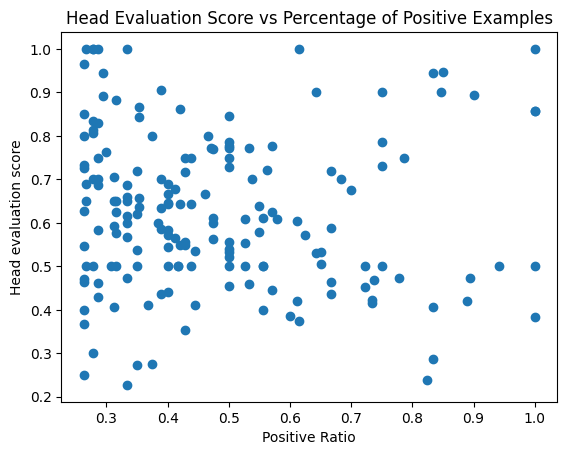

In [27]:
# print(categorised_prompts[(31, 3621, 468)][0])
categorised_prompts
nh_to_positive_ratio = {nh: len(categorised_prompts[nh][0]) / (len(categorised_prompts[nh][0]) + len(categorised_prompts[nh][1])) for nh in nh_list}
nh_to_positive_ratio

tprtnravg_and_posratio_tuples = []
for nh in nh_list:
    tprtnravg_and_posratio_tuples.append((nh_to_tpr_tnr_avg[nh], nh_to_positive_ratio[nh]))

y, x = zip(*tprtnravg_and_posratio_tuples)
from matplotlib import pyplot as plt
plt.scatter(x, y)
plt.ylabel("Head evaluation score")
plt.xlabel("Positive Ratio")
plt.title("Head Evaluation Score vs Percentage of Positive Examples")

Text(0, 0.5, 'Number of Heads')

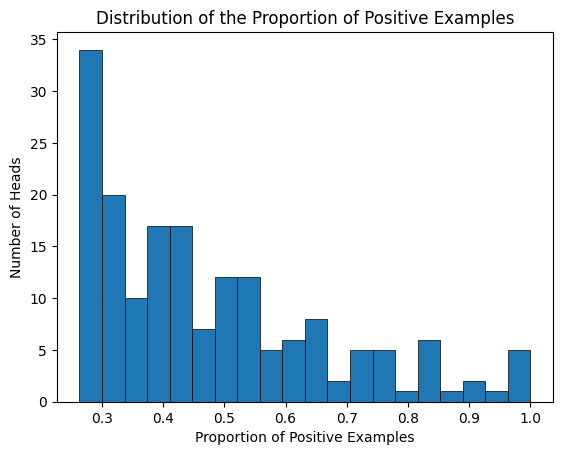

In [31]:
plt.hist(nh_to_positive_ratio.values(), linewidth=0.5, edgecolor="black", bins=20)
plt.title("Distribution of the Proportion of Positive Examples")
plt.xlabel("Proportion of Positive Examples")
plt.ylabel("Number of Heads")

In [48]:
def get_test_printout(nh):
    return_str = ""

    token = neuron_to_token[(nh[0], nh[1])]
    return_str += f"## Max Activating Examples from The Pile ('test' set)\n"
    return_str += f"This head is active when {nh_to_explanation[nh]}.\n"
    results = nh_to_egs_results[nh]
    tp, tn, fp, fn = results['tp'], results['tn'], results['fp'], results['fn']
    return_str += "Examples where the head is active:\n"
    for eg in results['tp']:
        return_str += f"✅ {eg + token}\n"
    for eg in results['fp']:
        return_str += f"❌ {eg + token}\n"

    return_str += "\nExamples where the head is inactive:\n"
    for eg in results['tn']:
        return_str += f"✅ {eg + token}\n"
    for eg in results['fn']:
        return_str += f"❌ {eg + token}\n"
    return_str += "\n"

    return return_str

x = get_test_printout((31,2918,505))
print(x)

## Max Activating Examples from The Pile ('test' set)
This head is active when contains the phrase "come and go" or variations of it, which implies a focus on things or events that happen temporarily, periodically, or cyclically. In these active examples, the attention head is likely picking up on the idea of change or transience. In the inactive examples, the phrase "come and go" or similar variations are not present, and instead, the word "go" is used in different contexts (such as comparisons, movement, or progress). As a result, the attention head is not active since the context it specializes in is not relevant in these examples..
Examples where the head is active:
✅  while baseball stadiums can come and go

Examples where the head is inactive:
✅  still have a ways to go
✅  Add beneficiaries to all your financial accounts and see an attorney for a will. “If something were to happen, this would go a long way toward reducing family stress,” says Mandi Woodruff, money expert at finan

In [34]:
# Find "while baseball stadiums can come and go" in the pile
for i, eg in enumerate(dataset):
    if "while baseball stadiums can come and go" in eg["text"]:
        print(i)
        print(eg["text"])


9231
Illustration By Rob Dobi

Where will the Oakland A's mascot Stomper be moving to? ... Our writer breaks down the team's possible new homes.

Photo By Scott Morris

The cranes at Howard Terminal, as seen from Jack London Square, would make for a postcard-worthy ballpark site. But some worry about access to the location, which is part of the Port of Oakland.

Views: The Howard Terminal Site



Photo By Scott Morris

Those hostile to the Laney College proposal cite displacement of nearby residents and traffic as major issues.

Squeezing In: The Laney College Site



Photo By Scott Morris

Under Dave Kaval's leadership, the A's added food trucks and games during certain A's home games this season. Some say staying at the Coliseum site is the path of least resistance.

Staying On The East Side:

The Coliseum Site



Photo By Scott Morris

Under Dave Kaval's leadership, the A's added food trucks and games during certain A's home games this season. Some say staying at the Coliseum site i

In [46]:
def get_train_printout(nh):
    token = neuron_to_token[(nh[0], nh[1])]
    
    return_str = ""
    return_str += f"{nh}, '{token}', {nh_to_tpr_tnr_avg[nh]}\n"
    positive_egs, negative_egs = categorised_prompts[nh]

    return_str += f"\n### Max-Activating Data from The Pile ('train' set)\n"

    return_str += "Examples where the attention head is active:\n"
    for i, positive_eg in enumerate(positive_egs):
        return_str += f"{i}. {positive_eg}\n"

    return_str += "\nExamples where the attention head is inactive:\n"
    for i, negative_eg in enumerate(negative_egs):
        return_str += f"{i}. {negative_eg}\n"

    return return_str

In [47]:
neuron_to_list_of_heads = {}
for neuron in neuron_to_token.keys():
    neuron_to_list_of_heads[neuron] = [nh for nh in nh_list_sorted_by_head_eval_score if (nh[0],nh[1]) == neuron]

total_str = ""

for neuron, list_of_nh in neuron_to_list_of_heads.items():
    total_str += f"###########################################\n"
    total_str += f"## {neuron} predicting '{neuron_to_token[neuron]}'\n"
    total_str += f"###########################################\n"
    for nh in list_of_nh:
        total_str += get_train_printout(nh)
        total_str += "\n"
        total_str += get_test_printout(nh)
        total_str += "-----------------------------------------------------\n"

# save total_str to text
with open("data/total_overview.txt", "w") as f:
    f.write(total_str)